In [1]:
%pylab inline
import numpy as np
import pandas as pd

from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

Populating the interactive namespace from numpy and matplotlib


# AdaGrad

* [Deep Learning 책 참고 299page](https://books.google.co.kr/books/about/Deep_Learning.html?id=Np9SDQAAQBAJ&redir_esc=y)
* [An overview of gradient descent optimization algorithms](http://sebastianruder.com/optimizing-gradient-descent/index.html#fn:24)

Stochastic Gradient Descent (SGD)는 convex 또는 non-convex function의 optimization에 일반적으로 사용되는 알고리즘입니다.<br>
SGD의 한가지 문제점은 learning rate에 매우 민감합니다. 특히 데이터가 sparse이며 features가 서로다른 frequencies (빈도수)를 갖고 있다면, 단 하나의 learning rate가 모든 weight update에 영향을 주는것은 문제가 될 수 있습니다. 

이전의 Momentum update에서는 다음과 같은 공식을 사용했습니다. 

$$ \begin{align}
v &= \gamma v_{t-1} + \eta \nabla_{\theta} J(\theta; x^{(i)},y^{(i)}) \\
\theta &= \theta - v
\end{align} $$

즉 모든 weights $ \theta $에 대해서 동일한 learning rate $ \eta $ 를 사용하여 update를 하였습니다. 


AgaGrad는 각각의 데이터에 dynamically adapt함으로서 궁극적으로 각각의 feature들마다 서로다른 learning rate로 연산을 합니다.<br>
쉽게 이야기해서, 빈도수가 낮은 데이터에는 높은 learning rate를 적용하고, 빈도수가 높은 데이터에는 낮은 learning rate를 자동으로 적용합니다. <br>
따라서 sparse한 데이터에 적합하며, 대표적인 예가 구글 X lab에서 16000대의 cores를 사용하여 유튜브 동영상안의 고양이를 detection하는 모델에 Adagrad를 사용한것입니다. 





* Global Learning Rate $ \eta $ 가 필요합니다. 
* weights $ \theta $에 대한 초기화가 필요합니다.
* small constant $ \epsilon $ 값을 설정합니다. (numerical stability를 위해서 약 $ 10^{-8} $로 설정, 즉 분모에 들어가게 되는데 0이 안되도록 매우 작은 수를 넣음)
* gradient accumulation variable $ G $값은 weight와 동일한 shape인 0으로 초기화합니다.

먼저 gradient를 구한뒤 sqaured gradient (gradient의 제곱)을 r에 accumulation해줍니다.

$$ \begin{align}
g_t &= \nabla_{\theta} J(\theta; x^{(i)}, y^{(i)}) \\ 
G_t &= G_t + g_t \odot g_t 
\end{align} $$ 

update를 계산합니다. 

$$ \Delta \theta_t =  \frac{\eta}{\epsilon + \sqrt{G_t}} \odot g_t $$

update를 적용합니다. 

$$ \theta_{t+1} = \theta_t - \Delta \theta_t $$

> $ \odot $ 기호는 element wise multiplication 입니다 

AdaGrad의 장점은 보통 다른 optimizers의 경우에는 learning rate를 일반적으로 0.01로 놓고 변경되지 않지만, Adagram같은 경우는 자동으로 learning rate를 계산해준다는 것입니다. 반면 약점은 denominator부분의 accumulation of the squared gradients의 값이 지속적으로 쌓여서 계속 늘어난다는 단점이 있습니다. 결국 learning rate는 점점 작아진다는 약점을 갖고있습니다. 이러한 약점은 극복한 것이 Adadelta입니다.


### Data

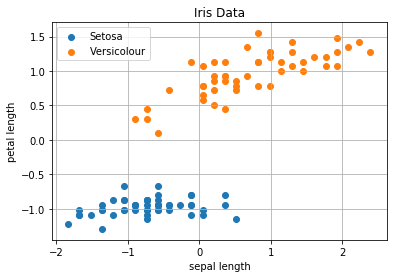

In [386]:
iris = load_iris()

# setosa_x = iris.data[:50]
# setosa_y = iris.target[:50]
# versicolor_x = iris.data[50:100]
# versicolor_y = iris.target[50:100]
# scatter(setosa_x[:, 0], setosa_x[:, 2])
# scatter(versicolor_x[:, 0], versicolor_x[:, 2])

# Extract sepal length, petal length from Setosa and Versicolor
data = iris.data[:100, [0, 2]]

# Standardization
scaler = StandardScaler()
data = scaler.fit_transform(data)


# Split data to test and train data
train_x, test_x, train_y, test_y = train_test_split(data, iris.target[:100], test_size=0.3)

# Plotting data
scatter(data[:50, 0], data[:50, 1], label='Setosa')
scatter(data[50:100, 0], data[50:100, 1], label='Versicolour')
title('Iris Data')
xlabel('sepal length')
ylabel('petal length')
grid()
legend()

### Stochastic Gradient Descent with AdaGrad Optimizer

In [405]:
w = np.array([ 0.09370901, -0.24480254, -0.84210235]) # np.random.randn(2 + 1)

def predict(w, x):
    N = len(x)
    yhat = w[1:].dot(x.T) + w[0]
    return yhat

def  adagrad_nn2(w, X, Y, eta=0.01, acmu_size=1):
    """
    @param eta <float>: learning rate
    @param acmu_size <int>: the size of the accumulation of the squred of the gradients with regard to theta
    """
    N = len(X)
    e = 1e-8
    G = np.zeros_like(w)
    
    i = 0
    for i in range(N):
        x = X[i]
        y = Y[i]
        yhat = predict(w, x)
        
        # Calculate the gradients
        gradient_w = 2/N*-(y-yhat)*x
        gradient_b = 2/N*-(y-yhat)
        
        G[1:] += gradient_w * gradient_w
        G[0] += gradient_b * gradient_b
        delta_w = eta/(e + np.sqrt(G[1:])) * gradient_w
        delta_b = eta/(e + np.sqrt(G[0])) * gradient_b
        w[1:] = w[1:] - delta_w
        w[0] = w[0] - delta_b
        
        if np.linalg.norm(w) < 1e-3:
            break
    return w

for i in range(20):
    w = adagrad_nn2(w, train_x, train_y)
    yhats = predict(w, test_x)
    yhats = np.where(yhats >= 0.5, 1, 0)
    accuracy = accuracy_score(test_y, yhats)
    print('Accuracy:', round(accuracy, 2), '\t\tweights:', w)

Accuracy: 0.0 		weights: [ 0.13311942 -0.13196347 -0.70207509]
Accuracy: 0.0 		weights: [ 0.17517404 -0.02139136 -0.5622791 ]
Accuracy: 0.03 		weights: [ 0.22024669  0.08566276 -0.42306429]
Accuracy: 0.4 		weights: [ 0.26857055  0.1866223  -0.28535928]
Accuracy: 0.6 		weights: [ 0.31970458  0.27497968 -0.15187859]
Accuracy: 0.83 		weights: [ 0.37118095  0.33185828 -0.03023366]
Accuracy: 0.9 		weights: [ 0.41775365  0.33561797  0.06756387]
Accuracy: 0.93 		weights: [ 0.45451793  0.30855672  0.14049942]
Accuracy: 0.97 		weights: [ 0.48013352  0.27088363  0.19729631]
Accuracy: 0.97 		weights: [ 0.49592062  0.23050147  0.24497723]
Accuracy: 0.97 		weights: [ 0.50425995  0.19049694  0.28725931]
Accuracy: 0.97 		weights: [ 0.50761714  0.15210897  0.32572912]
Accuracy: 0.97 		weights: [ 0.50804359  0.11597703  0.36093549]
Accuracy: 0.97 		weights: [ 0.50702581  0.08260442  0.39296609]
Accuracy: 1.0 		weights: [ 0.50552161  0.05245024  0.42172069]
Accuracy: 1.0 		weights: [ 0.50406479  0.02586